#### PR-кривая

In [1]:
# Загрузка необходимых библиотек

import numpy as np #для матричных вычислений
import pandas as pd #для обработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений

# Устанавливаем стиль визуализаций в matplotlib
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [2]:
#Первичный анализ дата-сета
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

#Заполним пропуски медаиной в зависимост от класса воды
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

# Разделим выборку на набор данных X и вектор ответов y
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']


# Разобъем датасет на тренировочную и тестовую (валидационную) выборки
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_valid.shape}')

Train shape: (2620, 9)
Test shape: (656, 9)


In [ ]:
# Строим модель дерева
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42
)

# обучаем модель
model.fit(X_train, y_train)
# создаем кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#делаем предсказание ВЕРОЯТНОСТЕй (proba) на кросс-валидации
y_cv_pred_proba = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
print(y_cv_pred_proba)

[[0.         1.        ]
 [0.24561404 0.75438596]
 [1.         0.        ]
 ...
 [0.60621762 0.39378238]
 [1.         0.        ]
 [0.03030303 0.96969697]]


In [4]:
#выделяем столбец с вероятностями для класса 1
y_cv_pred_proba = y_cv_pred_proba[:, 1]
y_cv_pred_proba

array([1.        , 0.75438596, 0.        , ..., 0.39378238, 0.        ,
       0.96969697])

In [5]:
# вычислим координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_pred_proba)
print('Thresholds', thresholds[:5])#выведем первые пять значений для примера, всего значений 94
print('Precision', precision[:5])
print('Recall', recall[:5])

Thresholds [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall [1.         0.9667319  0.96379648 0.95792564 0.95694716]


##### Далее построим PR-кривую и отметим на ней точку максимума F1-score

Вычислим значение F1-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

In [6]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall) #вернем 94 значения f1_score и передадим ее в функцию

#определим индекс максимума
idx = np.argmax(f1_scores) # из получившегося массива значений вернем индекс максимальноq f1-score (33) и вернем тресхолд по этому индексу
# мы определили порог вероятности-тресхолд при максимальной f1-score
print(f'idx = {idx}')
print(f'Best threshold = {thresholds[idx]:.2f}, F1-Score = {f1_scores[idx]:.2f}') # возвращаем значения с индексом 33


idx = 33
Best threshold = 0.33, F1-Score = 0.69


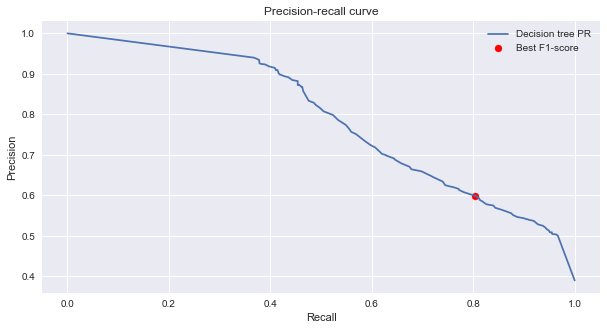

In [ ]:
# Строим PR-curve
fig, ax = plt.subplots(figsize=(10, 5)) # фигура и координатная плоскость
ax.plot(recall, precision, label='Decision tree PR') # строим линейный график зависимости precision от recall
ax.scatter(recall[idx], precision[idx], marker='o', color='red', label='Best F1-score') #Отмечаем точку максимума F1-score
# Подписываем график и оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#отображаем легенду
ax.legend();

In [15]:
# Задаем оптимальный порог вероятности
treshold_opt = 0.33

#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > treshold_opt).astype('int')
#Возвращаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [18]:
#Считаем площадь PR-curve
print(f'PR AUC {metrics.auc(recall, precision):.2}')
#PR AUC 0.79

PR AUC 0.79
